# Exploration Workbook for Texas Land Temps

In [1]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Acquire

In [2]:
#read in the csv locally
df = pd.read_csv('GlobalLandTemperaturesByState.csv')
df.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil


In [3]:
#check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


## Prepare

In [4]:
#Filter for State of Texas
df = df[df.State == 'Texas']

In [5]:
#Check the shape of the df
df.shape

(2325, 5)

In [6]:
#Validate all of the observations are Tx and only Tx
df.State.nunique()

1

In [7]:
#Check the info and see if there are any nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 549727 to 552051
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2325 non-null   float64
 2   AverageTemperatureUncertainty  2325 non-null   float64
 3   State                          2325 non-null   object 
 4   Country                        2325 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.0+ KB


In [8]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [9]:
#Set dt to be datetime format
df['dt'] = pd.to_datetime(df.dt, format='%Y-%m-%d')

In [10]:
#set date time back to index
df = df.set_index('dt').sort_index()

In [11]:
#Drop State and Country since I know I am working with all Texas Data
df.drop(columns={'State', 'Country'}, inplace=True)

In [12]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [13]:
#Check the stats 
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2325.000000,2325.000000
mean,18.107234,0.794785
std,7.413791,0.893291
min,1.965000,0.044000
25%,11.206000,0.180000
50%,18.378000,0.310000
75%,25.398000,1.241000
max,31.401000,4.950000


<AxesSubplot:>

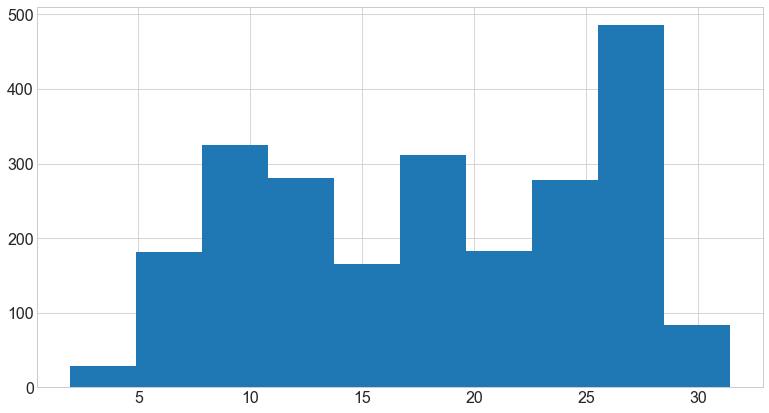

In [14]:
#Visualize the avg temp dist
df.AverageTemperature.hist()

<AxesSubplot:>

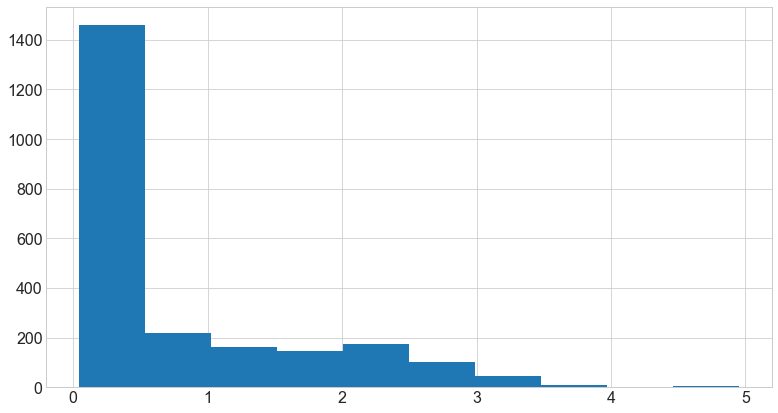

In [15]:
#Visualize the uncertainty dist
df.AverageTemperatureUncertainty.hist()

In [16]:
#Check the date range in years
print(f'The number of years in data is: {df.index.year.max() - df.index.year.min()}')
print(f'The oldest date in the data is: {df.index.min()}')
print(f'The most recent date in the data is: {df.index.max()}')

The number of years in data is: 193
The oldest date in the data is: 1820-01-01 00:00:00
The most recent date in the data is: 2013-09-01 00:00:00


**Question: What is the avgerage land temp for Texas in 1820 - 1890 (70 years) compared to 1942 - 2012 (70 years)?**

In [17]:
#Create a data frame for the first 80 years (time before 1900)
first_80_years = df[df.index.year <  1900]
first_80_years.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [18]:
#Create a dataframe for the most previous 80 years
last_80_years = df[df.index.year >= 1932]
last_80_years.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1932-01-01,8.544,0.421
1932-02-01,13.477,0.322
1932-03-01,11.289,0.234
1932-04-01,18.776,0.173
1932-05-01,22.035,0.130


In [19]:
print(f'The avg Texas land temp for years before 1900 is: {round(first_80_years.AverageTemperature.mean(), 2)} C')
print(f'The avg Texas land temp for years from 1932 to 2012 is: {round(last_80_years.AverageTemperature.mean(),2)} C')
print(f'The difference in avg Texas land temp between the two samples is: {round(last_80_years.AverageTemperature.mean() - first_80_years.AverageTemperature.mean(), 2)} C')

The avg Texas land temp for years before 1900 is: 17.79 C
The avg Texas land temp for years from 1932 to 2012 is: 18.45 C
The difference in avg Texas land temp between the two samples is: 0.66 C


**Question: What is the avgerage land temp UNCERTAINTY for Texas in 1820 - 1890 (70 years) compared to 1942 - 2012 (70 years)?**

In [20]:
print(f'The avg Texas land temp UNCERTAINTY for years before 1900 is: {round(first_80_years.AverageTemperatureUncertainty.mean(), 2)} C')
print(f'The avg Texas land temp UNCERTAINTYfor years from 1932 to 2012 is: {round(last_80_years.AverageTemperatureUncertainty.mean(),2)} C')
print(f'The difference in avg Texas land temp UNCERTAINTY between the two samples is: {round(last_80_years.AverageTemperatureUncertainty.mean() - first_80_years.AverageTemperatureUncertainty.mean(), 2)}')

The avg Texas land temp UNCERTAINTY for years before 1900 is: 1.61 C
The avg Texas land temp UNCERTAINTYfor years from 1932 to 2012 is: 0.19 C
The difference in avg Texas land temp UNCERTAINTY between the two samples is: -1.43


**Takeaways: Since the avg uncertainity in temps prior to 1900 is greater than the avg temp uncertainity since 1900...this may skew the data significantly...and I may want to control for year and use only the observations for after 1900.**

### Split the data

In [21]:
#Define the train size
train_size = int(len(df) * .5)
train_size

1162

In [22]:
#Define Validate size
validate_size = int(len(df) * .3)
validate_size

697

In [23]:
#Define Test size
test_size = int(len(df) - train_size - validate_size)
test_size

466

In [24]:
#Define the end to the validate df
validate_end_index = train_size + validate_size
validate_end_index

1859

In [25]:
#Split the data into three dataframes
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [26]:
#Check that the split is accurate
print(len(train) + len(validate) + len(test) == len(df))

True


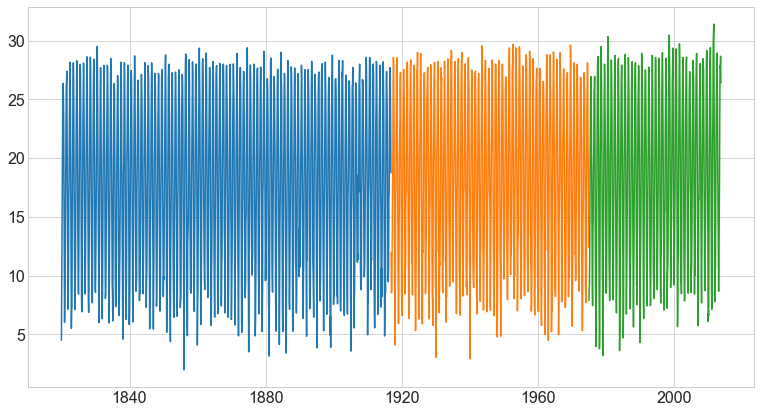

In [27]:
#Visulaize the three splits to ensure that each split captures a complete season, cycle, trend
plt.plot(train.index, train.AverageTemperature)
plt.plot(validate.index, validate.AverageTemperature)
plt.plot(test.index, test.AverageTemperature)

## Exploration

### Explore Average Land Temperatures

In [28]:
#Create a column for month
train['month'] = train.index.month_name()

In [29]:
#Set the target to y
y = train.AverageTemperature
y.head()

dt
1820-01-01     4.489
1820-02-01     9.081
1820-03-01    12.657
1820-04-01    19.215
1820-05-01    22.577
Name: AverageTemperature, dtype: float64

**What is the distribution of Texas Land Temps by month? By year?**

[Text(0.5, 1.0, 'Average Land Temperatures (C) by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Freq of Temp Observation')]

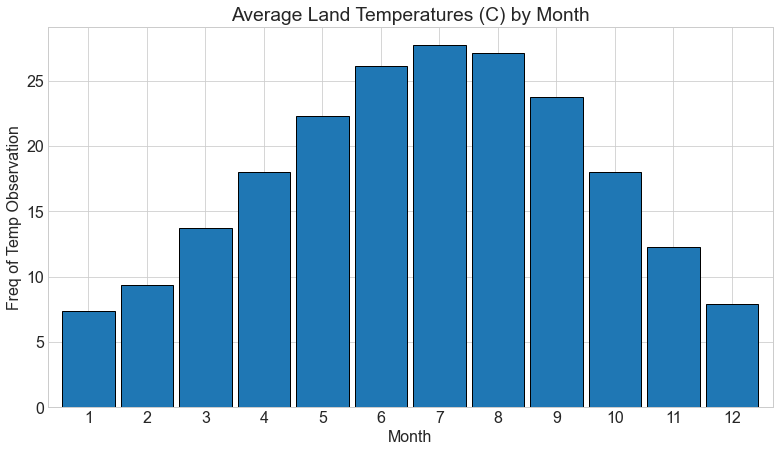

In [30]:
#Plot the dist of avg_temps by month

ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')

plt.xticks(rotation=0)

ax.set(title='Average Land Temperatures (C) by Month', xlabel='Month', ylabel='Freq of Temp Observation')

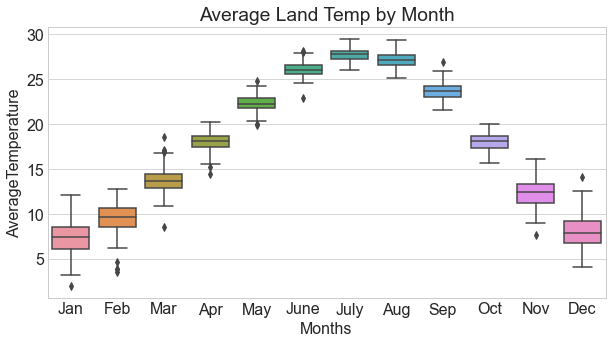

In [31]:
#Boxplot
plt.figure(figsize=(10, 5))
g = sns.boxplot(data = train, x = 'month', y = 'AverageTemperature')
plt.title('Average Land Temp by Month')
g.set(xticklabels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.show()

[Text(0.5, 1.0, 'Average Land Temperatures (C) by Year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Freq of Temp Observation')]

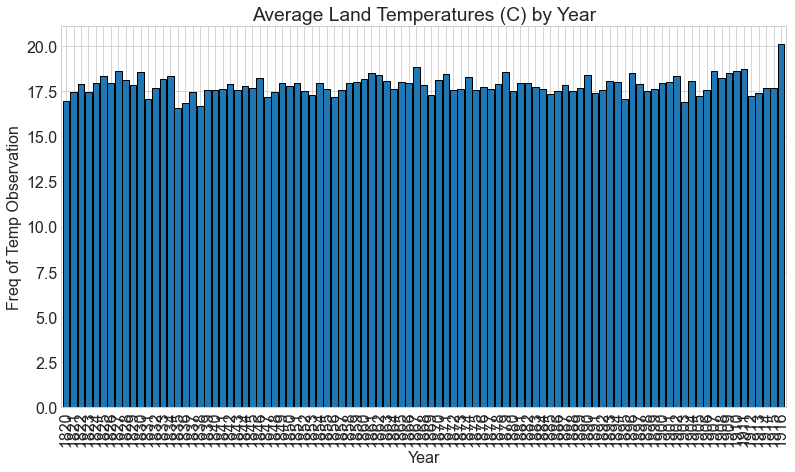

In [32]:
#Plot the dist of avg_temps by month

ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')

plt.xticks(rotation=90)

ax.set(title='Average Land Temperatures (C) by Year', xlabel='Year', ylabel='Freq of Temp Observation')

**Takeaways:**<br>
Month land temp is Normally distributed<br>
Not a ton of variance in land temp by year<br>
A lot of noise need reduction

**Explore Texas Land Temps with Noise Reduction**

Text(0.5, 1.0, 'Avg Texas Land Temp Rolling Averages')

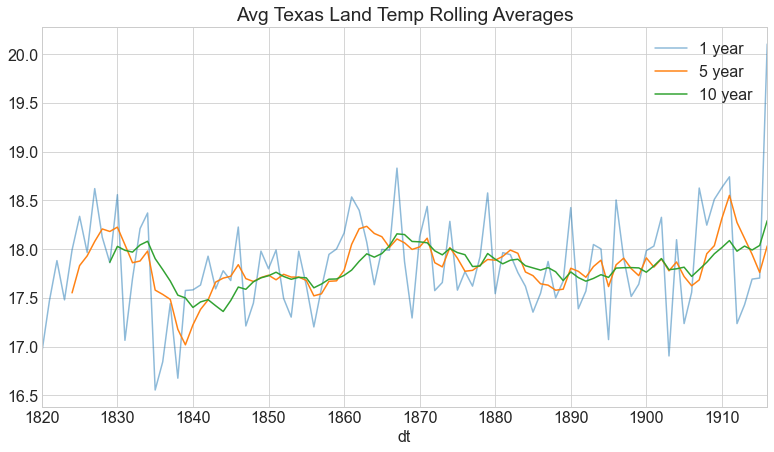

In [33]:
#Visualize with rolling averages to reduce noise
y.resample('Y').mean().rolling(1).mean().plot(alpha=.5, label='1 year')
y.resample('Y').mean().rolling(5).mean().plot(alpha=8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=8, label='10 year')
plt.legend()
plt.title('Avg Texas Land Temp Rolling Averages')

### Explore Average Temperature Uncertainty

In [34]:
#Set the target to y
y = train.AverageTemperatureUncertainty
y.head()

dt
1820-01-01    3.369
1820-02-01    2.873
1820-03-01    2.423
1820-04-01    2.501
1820-05-01    2.495
Name: AverageTemperatureUncertainty, dtype: float64

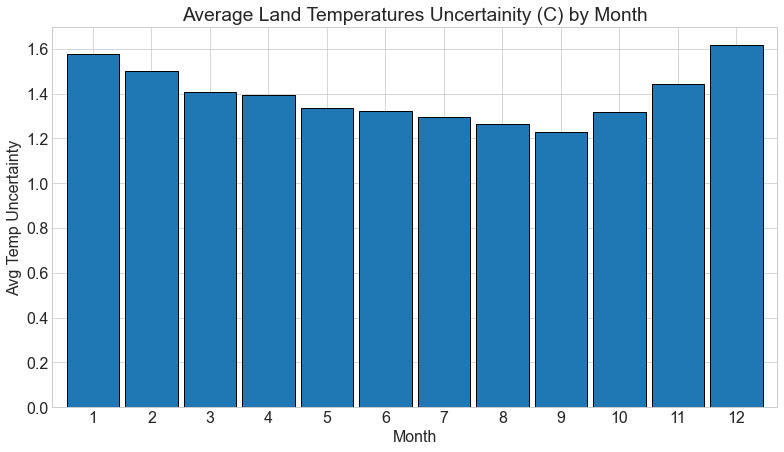

In [35]:
#Plot the dist of uncertainity by month

ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')

plt.xticks(rotation=0)

ax.set(title='Average Land Temperatures Uncertainity (C) by Month', xlabel='Month', ylabel='Avg Temp Uncertainty')
plt.show()

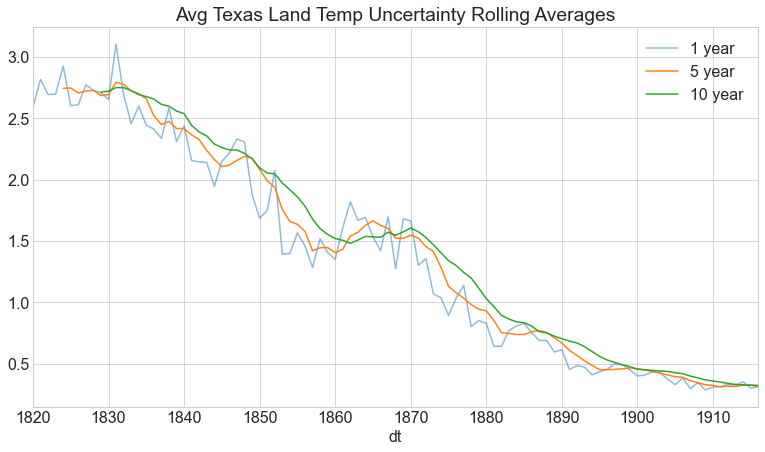

In [36]:
#Visualize with rolling averages to reduce noise
y.resample('Y').mean().rolling(1).mean().plot(alpha=.5, label='1 year')
y.resample('Y').mean().rolling(5).mean().plot(alpha=8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=8, label='10 year')
plt.legend()
plt.title('Avg Texas Land Temp Uncertainty Rolling Averages')
plt.show()

**Takeaways:**<br>
- The variance in uncertainty decreases as time goes on; specifically it flattens from ~1900 onward<br>
- Is this due to actual variatations in temperatures driving the uncertainity or better tools and methods for measuring?

In [37]:
#Drop the month column prior to modeling
train.drop(columns={'month'}, inplace=True)

## Modeling

**Define automation functions for evaluating and plotting model results**

In [38]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature], 
                        'AverageTemperatureUncertainty': [AverageTemperatureUncertainty]}, 
                      index = validate.index)
    return yhat_df

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.2f}'.format(rmse))
    plt.show()
    
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

**Last Observed Value**

In [39]:
#Obtain last observed avg_temp value
AverageTemperature = round(train['AverageTemperature'][-1:][0], 2)
AverageTemperature

18.74

In [40]:
#obtain last observed avg_uncertainity value
AverageTemperatureUncertainty = round(train['AverageTemperatureUncertainty'][-1:][0], 2)
AverageTemperatureUncertainty

0.22

In [41]:
#Create the yhat dataframe and fill with last observed values
yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature], 
                        'AverageTemperatureUncertainty': [AverageTemperatureUncertainty]}, 
                      index = validate.index)

yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,18.74,0.22
1916-12-01,18.74,0.22
1917-01-01,18.74,0.22
1917-02-01,18.74,0.22
1917-03-01,18.74,0.22


In [42]:
#Confirm that all the values are the same as expected
yhat_df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,6.970000e+02,6.970000e+02
mean,1.874000e+01,2.200000e-01
std,1.813185e-13,9.721428e-16
min,1.874000e+01,2.200000e-01
25%,1.874000e+01,2.200000e-01
50%,1.874000e+01,2.200000e-01
75%,1.874000e+01,2.200000e-01
max,1.874000e+01,2.200000e-01


AverageTemperature -- RMSE: 7.00


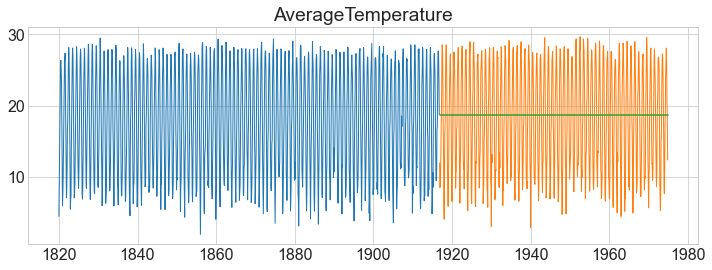

AverageTemperatureUncertainty -- RMSE: 0.00


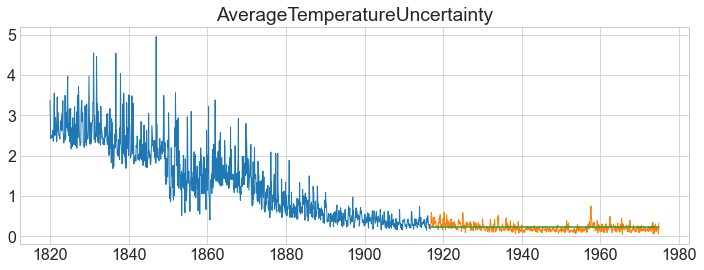

In [43]:
#Plot actual vs predicted 
for col in train.columns:
    plot_and_eval(col)

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0


**Simple Average**

In [45]:
#Obtain simple avg for avg temp 
AverageTemperature = round(train['AverageTemperature'].mean(), 2)

#obtain simple avg_uncertainity
AverageTemperatureUncertainty = round(train['AverageTemperatureUncertainty'].mean(), 2)

AverageTemperature, AverageTemperatureUncertainty

(17.83, 1.39)

In [46]:
#make predictions with simple average
yhat_df = make_predictions()

In [47]:
yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,17.83,1.39
1916-12-01,17.83,1.39
1917-01-01,17.83,1.39
1917-02-01,17.83,1.39
1917-03-01,17.83,1.39


AverageTemperature -- RMSE: 7.00


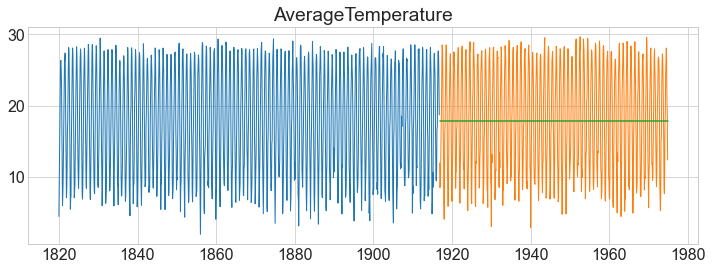

AverageTemperatureUncertainty -- RMSE: 1.00


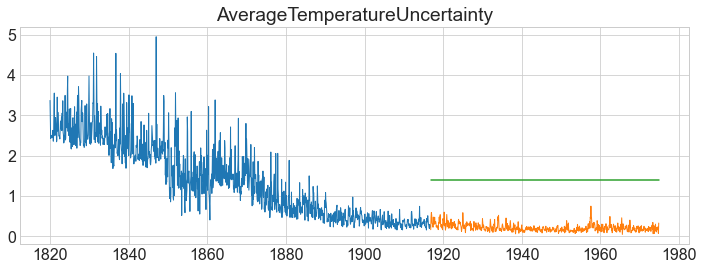

In [48]:
for col in train.columns:
    plot_and_eval(col)

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0
2,simple_average,AverageTemperature,7.0
3,simple_average,AverageTemperatureUncertainty,1.0


**Moving Average**

In [50]:
periods = [1, 5, 10, 20, 30]

for p in periods: 
    AverageTemperature = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
    AverageTemperatureUncertainty = round(train['AverageTemperatureUncertainty'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'y_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [51]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0
2,simple_average,AverageTemperature,7.0
3,simple_average,AverageTemperatureUncertainty,1.0
4,1y_moving_avg,AverageTemperature,7.0
5,1y_moving_avg,AverageTemperatureUncertainty,0.0
6,5y_moving_avg,AverageTemperature,10.0
7,5y_moving_avg,AverageTemperatureUncertainty,0.0
8,10y_moving_avg,AverageTemperature,8.0
9,10y_moving_avg,AverageTemperatureUncertainty,0.0


### Holt's Linear Trend

AverageTemperature 



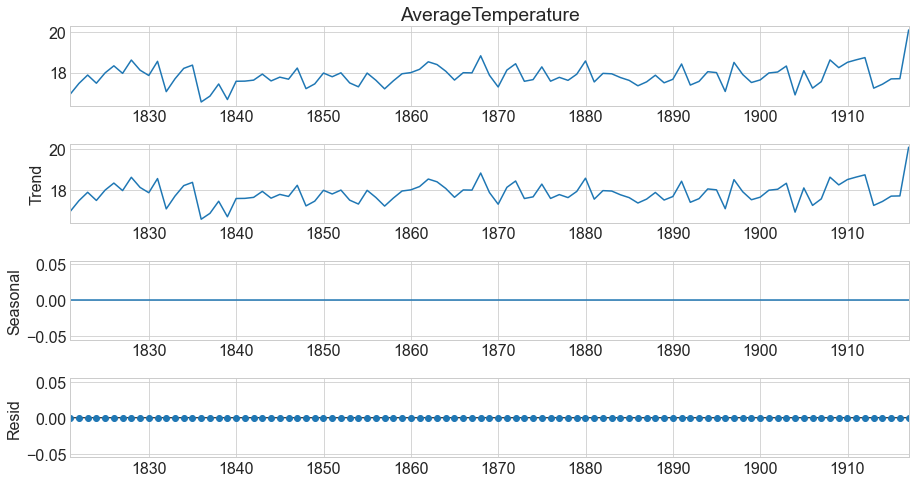

AverageTemperatureUncertainty 



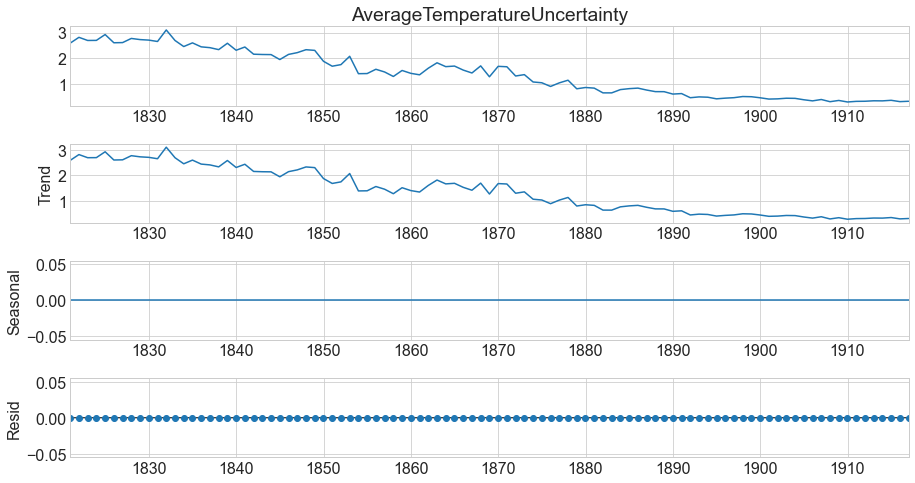

In [52]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

In [53]:
for col in train.columns:
    model = Holt(train[col], exponential=True, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [54]:
yhat_df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1916-11-01,16.08,0.3
1916-12-01,14.03,0.3
1917-01-01,12.58,0.3
1917-02-01,11.53,0.3
1917-03-01,10.75,0.3


AverageTemperature -- RMSE: 13.00


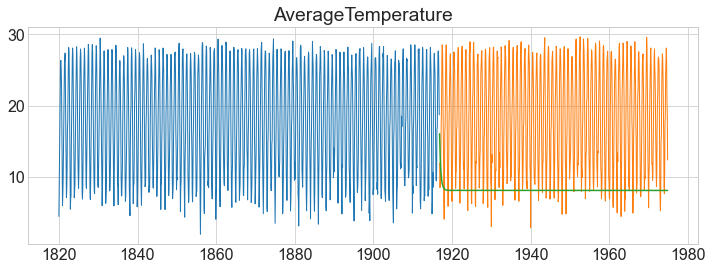

AverageTemperatureUncertainty -- RMSE: 0.00


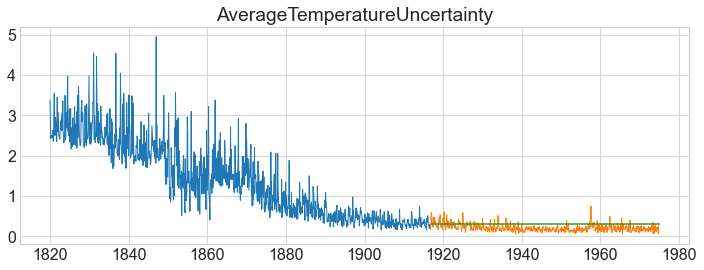

In [55]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [56]:
#append eval dataframe with holts optimized model evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [57]:
#Review performance metrics for all models thus far
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.0
1,last_observed_value,AverageTemperatureUncertainty,0.0
2,simple_average,AverageTemperature,7.0
3,simple_average,AverageTemperatureUncertainty,1.0
4,1y_moving_avg,AverageTemperature,7.0
5,1y_moving_avg,AverageTemperatureUncertainty,0.0
6,5y_moving_avg,AverageTemperature,10.0
7,5y_moving_avg,AverageTemperatureUncertainty,0.0
8,10y_moving_avg,AverageTemperature,8.0
9,10y_moving_avg,AverageTemperatureUncertainty,0.0


**Previous Cyle**

In [58]:
#Split the original dataframe into train, validate and test based on the previous cycle
train = df[:'2010']
validate = df['2011']
test = df['2012']

#Print the shape of each dataframe
print(train.shape)
print(validate.shape)
print(test.shape)

(2292, 2)
(12, 2)
(12, 2)


In [59]:
# finding the year-over-year difference for each day from 1820 to 2010
# taking the mean, and then adding that value to the daily 2010 values. 

yhat_df = train['2010'] + train.diff(365).mean()

In [60]:
# let's peek into the prediction we will make for 1/1/2011
# by comparing the predicted value 
# (2010 value + year-over-year average difference)
# to the actual 1/1/2011 value
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2010-01-01,6.924656,-0.31578
2011-01-01,7.121000,0.19800


In [61]:
# set yhat_df to index of validate

yhat_df.index = validate.index

yhat_df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,12.000000,12.000000
mean,18.675240,-0.265947
std,8.488843,0.055256
min,6.785656,-0.331780
25%,12.101906,-0.312780
50%,19.227656,-0.278280
75%,26.312906,-0.226780
max,29.569656,-0.151780


AverageTemperature -- RMSE: 2.00


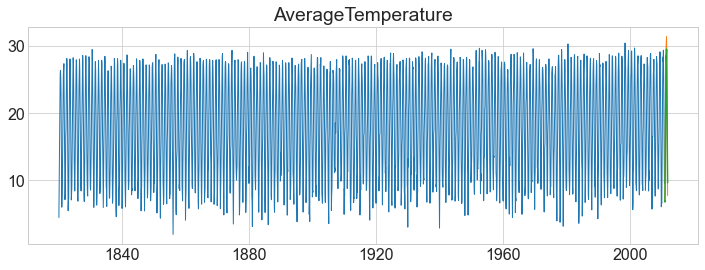

AverageTemperatureUncertainty -- RMSE: 0.00


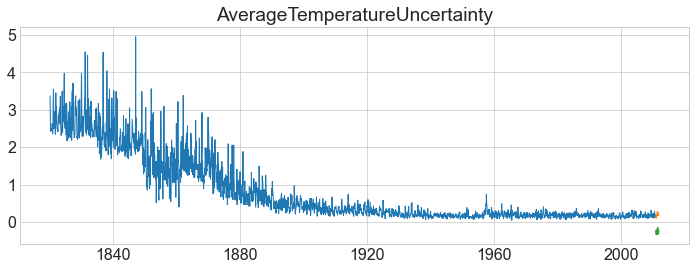

In [62]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cylce", 
                            target_var = col)

In [63]:
AverageTemperature_min_rmse= eval_df.groupby('target_var')['rmse'].min()[0]

AverageTemperatureUncertainty_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == AverageTemperature_min_rmse) | 
         (eval_df.rmse == AverageTemperatureUncertainty_min_rmse))]

,model_type,target_var,rmse
1,last_observed_value,AverageTemperatureUncertainty,0.0
5,1y_moving_avg,AverageTemperatureUncertainty,0.0
7,5y_moving_avg,AverageTemperatureUncertainty,0.0
9,10y_moving_avg,AverageTemperatureUncertainty,0.0
11,20y_moving_avg,AverageTemperatureUncertainty,0.0
13,30y_moving_avg,AverageTemperatureUncertainty,0.0
15,holts_optimized,AverageTemperatureUncertainty,0.0
16,previous_cylce,AverageTemperature,2.0
17,previous_cylce,AverageTemperatureUncertainty,0.0


**Takeaways:**<br>
The previous_cycle model performs the best with a mean error of 2 degrees C

**Use previous_cycle model for out of sample data**

In [64]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [65]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.xlim(left = 1990)
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [66]:
rmse_avg_temp = sqrt(mean_squared_error(test['AverageTemperature'], 
                                       yhat_df['AverageTemperature']))

rmse_avg_uncertainty = sqrt(mean_squared_error(test['AverageTemperatureUncertainty'], 
                                       yhat_df['AverageTemperatureUncertainty']))

In [67]:
print('rmse_avg_temp: ', rmse_avg_temp)
print('rmse_avg_uncertainty: ', rmse_avg_uncertainty)

rmse_avg_temp:  1.678426389948172
rmse_avg_uncertainty:  0.4702299003760622


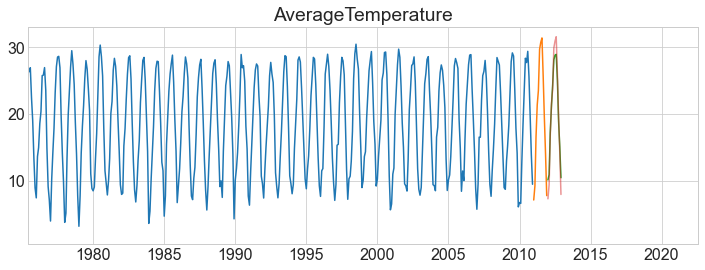

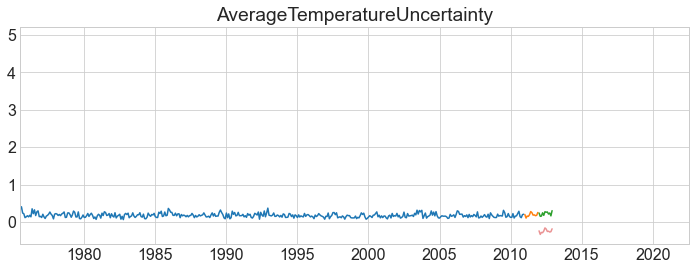

In [68]:
for col in train.columns:
    final_plot(col)

**Takeaways:**
- The previous cycle model performs well out of sample data with an average land temperature error of 1.68  degrees C

## Conclusion & Takeaways

1. The previous cycle model is the best performing model for predicting average land temperature and avg temperature uncertainity for the state of Texas.
2. Average temperature uncertianity has decreased, especially from 1900 onwards where it does plateu close to 0. This is assumed to be due to the fact of technological advances in equipment for measuring temperature.